> This is a self-correcting activity generated by [nbgrader](https://nbgrader.readthedocs.io). Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Run subsequent cells to check your code.

---

# Generate handwritten digits with a GAN (PyTorch)

The goal here is to train a GAN to generate handwritten digits.

## Environment setup

In [1]:
import os
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

import matplotlib
import matplotlib.pyplot as plt

Python version: 3.7.9


In [2]:
# Setup plots
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 8
%config InlineBackend.figure_format = 'retina'

In [14]:
import torch

print(f"PyTorch version: {torch.__version__}")
print("GPU found :)" if torch.cuda.is_available() else "No GPU :(")

import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PyTorch version: 1.4.0
No GPU :(


## Data loading

In [4]:
sample_dir = "samples"

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5]),  # only one channel
    ]
)

# MNIST dataset
mnist = torchvision.datasets.MNIST(
    root="../../data/", train=True, transform=transform, download=True
)

100.1%

Extracting ../../data/MNIST\raw\train-images-idx3-ubyte.gz to ../../data/MNIST\raw


113.5%

Extracting ../../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../../data/MNIST\raw


100.4%

Extracting ../../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../../data/MNIST\raw


180.4%

Extracting ../../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../../data/MNIST\raw
Processing...
Done!


### Question

Create batch data loader `data_loader` for training dataset.

In [6]:
batch_size = 100

# YOUR CODE HERE
data_loader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

## Model definition

### Question

Complete the following code to create a GAN:

- generator must be a dense network with two hidden layers using ReLU as activation functions;
- discriminator must be a dense network with two hidden layers using leaky ReLU as activation functions.

In [31]:
# Hyper-parameters
image_size = 784
hidden_size = 256
latent_size = 64

# Generator
G = nn.Sequential(
    # YOUR CODE HERE
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh()
)

# Discriminator
D = nn.Sequential(
    # YOUR CODE HERE
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid()
)

# Device setting
G = G.to(device)
D = D.to(device)

## Loss, optimizer and utilities

### Question

Define optimizers `d_optimizer` and `g_optimizer`, both using Adam with  a learning rate of 0.0002.

In [32]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
learning_rate = 0.0002

# YOUR CODE HERE

g_optimizer = optim.Adam(G.parameters(), lr=learning_rate)
d_optimizer = optim.Adam(D.parameters(), lr=learning_rate)

In [33]:
def denorm(x):
    """Denormalize an image tensor"""
    out = (x + 1) / 2
    return out.clamp(0, 1)


def reset_grad():
    """Reset gradients for both optimizers"""
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

## Model training

### Question

Complete the following training loop to:

- compute fake images and output during discriminator training; 
- implement gradient descent.

In [34]:
num_epochs = 50 # Increase for a better output quality
step_count = len(data_loader)

# Start training
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)

        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since y == real_labels == 1
        real_outputs = D(images)
        d_loss_real = criterion(real_outputs, real_labels)
        real_score = real_outputs

        # Compute BCELoss using fake images
        # First term of the loss is always zero since y == fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        
        # YOUR CODE HERE
        fake_outputs = D(G(z))
        d_loss_fake = criterion(fake_outputs, fake_labels)
        fake_score = fake_outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        
        # YOUR CODE HERE
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        

        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)

        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)

        # Backprop and optimize
        # YOUR CODE HERE
        reset_grad()
        g_loss.backward()
        g_optimizer.step()

        if (i + 1) % 200 == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}]"
                f", Step [{i + 1}/{step_count}]"
                f", d_loss: {d_loss.item():.4f}"
                f", g_loss: {g_loss.item():.4f}"
                f", D(x): {real_score.mean().item():.2f}"
                f", D(G(z)): {fake_score.mean().item():.2f}"
            )

    # Save real images
    if (epoch + 1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, "real_images.png"))

    # Save sampled images
    if (epoch + 1) % 10 == 0:
        fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
        save_image(
            denorm(fake_images),
            os.path.join(sample_dir, f"fake_images-{epoch + 1}.png"),
        )

Epoch [1/50], Step [200/600], d_loss: 0.1975, g_loss: 1.9949, D(x): 1.00, D(G(z)): 0.18
Epoch [1/50], Step [400/600], d_loss: 0.0153, g_loss: 5.4547, D(x): 1.00, D(G(z)): 0.01
Epoch [1/50], Step [600/600], d_loss: 0.0075, g_loss: 6.2718, D(x): 1.00, D(G(z)): 0.01
Epoch [2/50], Step [200/600], d_loss: 0.0032, g_loss: 7.4917, D(x): 1.00, D(G(z)): 0.00
Epoch [2/50], Step [400/600], d_loss: 0.1727, g_loss: 3.6808, D(x): 0.96, D(G(z)): 0.10
Epoch [2/50], Step [600/600], d_loss: 0.0535, g_loss: 5.9018, D(x): 0.97, D(G(z)): 0.01
Epoch [3/50], Step [200/600], d_loss: 0.0916, g_loss: 7.4300, D(x): 0.99, D(G(z)): 0.08
Epoch [3/50], Step [400/600], d_loss: 0.2262, g_loss: 3.5883, D(x): 0.95, D(G(z)): 0.12
Epoch [3/50], Step [600/600], d_loss: 0.3898, g_loss: 5.3554, D(x): 0.96, D(G(z)): 0.23
Epoch [4/50], Step [200/600], d_loss: 1.0051, g_loss: 3.6098, D(x): 0.67, D(G(z)): 0.08
Epoch [4/50], Step [400/600], d_loss: 0.7395, g_loss: 2.7631, D(x): 0.83, D(G(z)): 0.22
Epoch [4/50], Step [600/600], d_

## Generate digits

In [29]:
def plot_image(image):
    # Convert PyTorch tensor to NumPy
    img_tensor = image.cpu().detach().numpy() if torch.cuda.is_available() else image.detach().numpy()
    plt.imshow(img_tensor.squeeze(), cmap="binary")
    plt.axis("off")

def show_images(images, n_images=batch_size):
    fig = plt.figure(figsize=(6, 10))
    for image_index in range(n_images):
        plt.subplot(13, 8, 1 + image_index)
        plot_image(images[image_index])

### Question

Use the trained generator to create fake images from Gaussian noise.

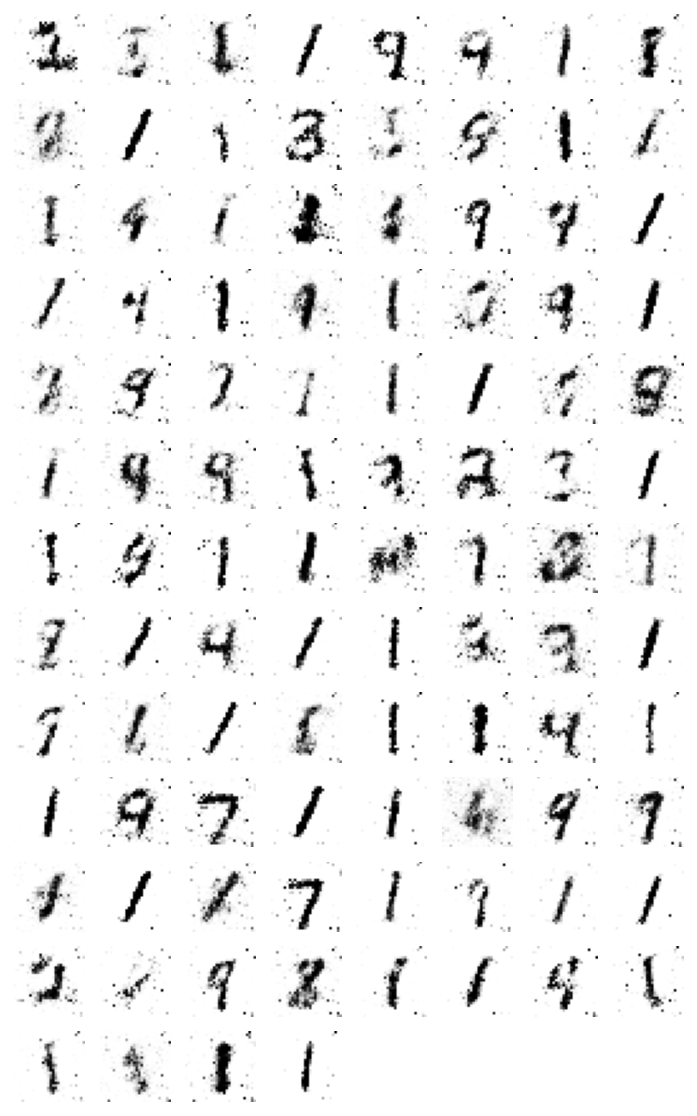

In [35]:
# YOUR CODE HERE
noise = torch.randn(batch_size, latent_size).to(device)
fake_images = G(noise)

with torch.no_grad():
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    show_images(fake_images)
